In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.distributions import norm, beta

In [2]:
import pymc3 as pm

# MCMC Coin Flipping

We'll work with the same coin-flipping model previously developed in class.

In [3]:
a = 1
b = 1
N = 100
z = 40

flip_model = pm.Model()

with flip_model:
    # Priors for unknown model parameters
    theta = pm.Beta('theta', alpha=a, beta=b)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('Y_obs', n=N, p=theta, observed=z)

Let's use a Metropolis sampler to have 2 chains evolve for 10000 steps.  

In [4]:
nsteps = 10000

with flip_model:
    # Use a Metropolis sampler, with a specific jump size and prevent tuning
    step = pm.Metropolis(scaling=.1, tune=False)
    
    # draw posterior samples
    trace = pm.sample(nsteps, step=step, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:02<00:00, 10142.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


and look at the trace.

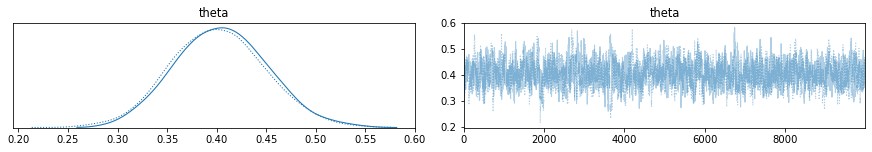

In [5]:
pm.traceplot(trace);

By eye, the traces of the two chains seem to agree (statistically speaking) fairly well, and there isn't expceptionally high correlation (though there is some).  Let's explore how to assess this more quantitatively.

## Gelman-Rubin Statistic

Comapares the variance of each chain to the pooled variance.  $\hat{R} < 1.001$ is usually pretty good.

In [6]:
pm.stats.rhat(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 1.002

# Autocorrelation

In [7]:
acf_0 = pm.stats.az.autocorr(trace.get_values('theta', chains=0))
acf_1 = pm.stats.az.autocorr(trace.get_values('theta', chains=1))

acf_0

array([ 1.00000000e+00,  9.07219529e-01,  8.23925587e-01, ...,
       -1.34670538e-04, -7.49050779e-05, -3.08937907e-05])

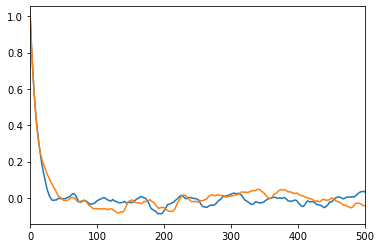

In [8]:
plt.plot(acf_0)
plt.plot(acf_1)
plt.xlim(0, 500);

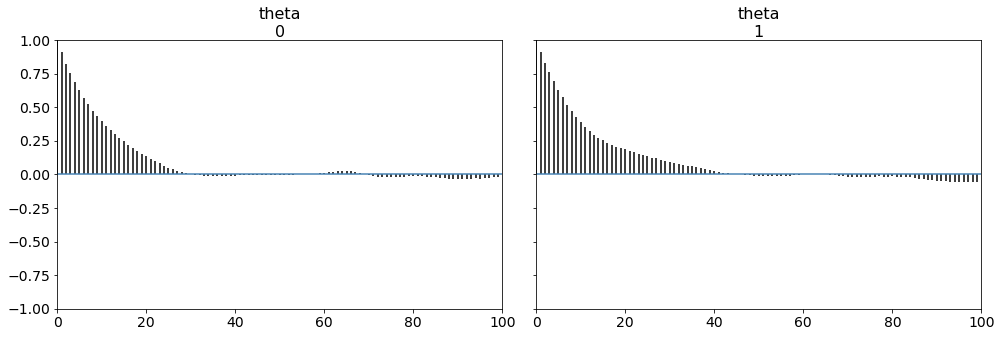

In [9]:
pm.autocorrplot(trace);

# Effective Sample Size

The effective sample size is the number of **independent** samples in a chain.

In [10]:
pm.effective_n(trace)

/opt/conda/lib/python3.7/site-packages/pymc3/stats/__init__.py:50: UserWarning: effective_n has been deprecated. In the future, use ess instead.
  warnings.warn("effective_n has been deprecated. In the future, use ess instead.")


<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 961.9

What about the NUTS sampler?  Resample with the NUTS sampler above and recalculate these statistics.